In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 5.4MB/s 
     |████████████████████████████████| 18.0MB 116kB/s 
     |████████████████████████████████| 235kB 40.7MB/s 
     |████████████████████████████████| 215kB 32.9MB/s 
     |████████████████████████████████| 2.1MB 31.0MB/s 
     |████████████████████████████████| 1.5MB 33.2MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 194kB 44.3MB/s 
     |████████████████████████████████| 71kB 406kB/s 
     |████████████████████████████████| 614kB 36.0MB/s 
     |████████████████████████████████| 3.2MB 35.5MB/s 
     |████████████████████████████████| 6.3MB 29.8MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=0e05e8d8e3e1f3c36cf3688c08925e33c57296b57898ee239386b0b5b2fbe19e
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [2]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.finance import QiskitFinanceError
from qiskit.finance.data_providers import WikipediaDataProvider
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#%matplotlib notebook

/usr/local/lib/python3.7/dist-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


## Pull Stock data

In [3]:
# set number of assets (= number of qubits)
#stocks = ["GOOG", "AAPL", "F", "NFLX", "AMZN", "INTC", "ADBE", "KHC", "IBM", "NVDA"]
#stocks = ["GOOG", "AAPL", "F", "NFLX", "AMZN", "INTC", "ADBE", "IBM"]
#stocks = ["GOOG", "AAPL", "MSFT", "F", "IBM"]
stocks = ["AMZN", "GOOG", "TSLA", "MSFT", "IBM"]
#stocks = ["AMZN", "GOOG", "NVDA", "MSFT"]
#stocks = ["CVX", "V", "PG", "JPM", "IBM"]
num_assets = len(stocks)

# This is my personal api key from Quandl!
token = "HRXZqqxBka_9huabBgoW"
# token = None

try:
    wiki = WikipediaDataProvider(
                        token = token,
                        tickers = stocks,
                        start = datetime.datetime(2018,1,1),
                        end = datetime.datetime(2018,12,1))
    wiki.run()
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

## Draw stock data
We also drew a normalised version of it as well

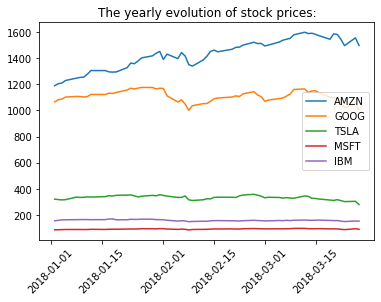

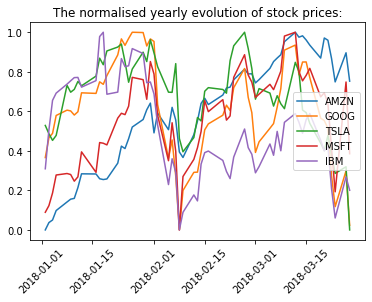

In [4]:
fig, axes = plt.subplots()
for (cnt, s) in enumerate(stocks):
    axes.plot(wiki._data[cnt], label=s)
plt.title("The yearly evolution of stock prices:")
plt.legend(loc="right")
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots()
for (cnt, s) in enumerate(stocks):
    min_ = np.min(wiki._data[cnt])
    max_ = np.max(wiki._data[cnt])
    norm = (wiki._data[cnt] - min_)/(max_- min_)
    axes.plot(norm, label=s)
plt.legend(loc="right")
plt.title("The normalised yearly evolution of stock prices:")
plt.xticks(rotation=45)
plt.show()


In [5]:
mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()

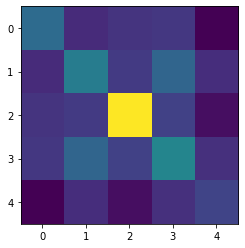

In [6]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [7]:
!pip install qiskit_nature

     |████████████████████████████████| 1.5MB 4.2MB/s 


In [8]:
from qiskit_nature.drivers import PySCFDriver

In [9]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()
#z2symmetry_reduction = "auto"
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
#converter = QubitConverter(mapper=mapper)
#converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
# The fermionic operators are mapped to qubit operators
#num_particles = (problem.molecule_data_transformed.num_alpha,
             #problem.molecule_data_transformed.num_beta)
#qubit_op = converter.convert(main_op, num_particles=num_particles)

## Set our Optimization Parameters

In [10]:

# set risk factor
q = 0.5
# set budget
budget = 2
# set parameter to scale the budget penalty term
penalty = num_assets




# Create a Qubit operator
qubitOp, converter  = portfolio.get_operator(mu, sigma, q, budget, penalty)

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 


if optimizer_type == 'COBYLA':
    cobyla = COBYLA()
    cobyla.set_options(maxiter=577)
elif optimizer_type == 'L_BFGS_B':
    l_bfgs_b = L_BFGS_B()
    cobyla.set_options(maxfun=500)
elif optimizer_type == 'SPSA':
    spsa = SPSA()
    spsa.set_options(maxiter=500)
elif optimizer_type == 'SLSQP':
    slsqp = SLSQP()
    slsqp.set_options(maxiter=500)    



# Prep for solvers
seed = 50



# Set up the quantum instance backend
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

## Classical Solver

In [11]:
# NumPyMinimumEigensolver (Classical Solver)
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
np_result = exact_eigensolver.run()

In [16]:
#hero
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
vqe_counts = []
vqe_values = []
# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
#num_particles = (problem.molecule_data_transformed.num_alpha,
             #problem.molecule_data_transformed.num_beta)
#num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['rxx', 'rzz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubitOp.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    #ansatz.compose(front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubitOp.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubitOp.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(front=True, inplace=True)

vqe = VQE(qubitOp, ansatz, cobyla)



vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

vqe_result = vqe.run(quantum_instance)
print(ansatz)

     ┌────────────┐                                                         »
q_0: ┤0           ├──■────────────────■────■────■────■──────────────■───────»
     │  RXX(θ[0]) │┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐  │    │              │       »
q_1: ┤1           ├┤ X ├┤ RZ(θ[2]) ├┤ X ├┤ X ├──┼────┼────■────■────┼───────»
     ├────────────┤└───┘└──────────┘└───┘└───┘┌─┴─┐  │  ┌─┴─┐  │    │       »
q_2: ┤0           ├──■────────────────■───────┤ X ├──┼──┤ X ├──┼────┼────■──»
     │  RXX(θ[1]) │┌─┴─┐┌──────────┐┌─┴─┐     └───┘┌─┴─┐└───┘┌─┴─┐  │  ┌─┴─┐»
q_3: ┤1           ├┤ X ├┤ RZ(θ[3]) ├┤ X ├──────────┤ X ├─────┤ X ├──┼──┤ X ├»
     └────────────┘└───┘└──────────┘└───┘          └───┘     └───┘┌─┴─┐└───┘»
q_4: ─────────────────────────────────────────────────────────────┤ X ├─────»
                                                                  └───┘     »
«          ┌────────────┐                                                   »
«q_0: ─────┤0           ├──■──────────────────■───────■─────────

## Top computed results for each solver

In [20]:
def find_best(result, name):
    eigenvector = result.eigenstate
    p_all = True
    if not isinstance(result.eigenstate, np.ndarray):
        p_all = False
        eigenvector = result.eigenstate.to_matrix()
        
    
    probabilities = np.abs(eigenvector)**2
    i_sorted = np.argsort(probabilities)[::-1]
    pl = []
    for i in i_sorted[:10]:
        x = "{0:b}".format(i).zfill(num_assets)
        arr = np.array([int(a) for a in list(x)])[::-1]
        value = portfolio.portfolio_value(arr, mu, sigma, q, budget, penalty)
        optim = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
        opt = "".join(optim).ljust(25)
        probability = probabilities[i]
        pl.append((opt, f'{arr} \t {opt} {round(value,4)} \t {round(probability,4)}'))

    print(name+' Optimal Stock Combination: '+''.join(pl[0][0]))
    print('\n------------------------------ Top Results ---------------------------------')
    print('qubits \t\t stock combination \t value \t\t probability')
    print('-------------------------------------------------------------------------------')
    [print(p[1]) for p in pl] if p_all else print(pl[0][1])
    print('-----------------------------------------------------------------------------\n')
        

find_best(vqe_result, "VQE")
find_best(np_result,  "Classical")

VQE Optimal Stock Combination: AMZN MSFT                

------------------------------ Top Results ---------------------------------
qubits 		 stock combination 	 value 		 probability
-------------------------------------------------------------------------------
[1 0 0 1 0] 	 AMZN MSFT                 -0.0044 	 0.666
[0 0 0 1 1] 	 MSFT IBM                  -0.0002 	 0.1914
[0 0 1 1 0] 	 TSLA MSFT                 0.002 	 0.1426
[1 0 1 1 1] 	 AMZN TSLA MSFT IBM        19.9993 	 0.0
[1 0 1 1 0] 	 AMZN TSLA MSFT            4.9985 	 0.0
[0 0 0 1 0] 	 MSFT                      4.9993 	 0.0
[1 0 0 1 1] 	 AMZN MSFT IBM             4.9962 	 0.0
[0 0 1 1 1] 	 TSLA MSFT IBM             5.0026 	 0.0
[0 1 1 0 0] 	 GOOG TSLA                 0.0036 	 0.0
[1 0 1 0 1] 	 AMZN TSLA IBM             4.9993 	 0.0
-----------------------------------------------------------------------------

Classical Optimal Stock Combination: AMZN MSFT                

------------------------------ Top Results --------